Illustris Black Hole Merger Frequency vs Redshift Analysis
--------------------------------------------------------

Retrieving simulation information...
Selected simulation: TNG100-1
Retrieving snapshot information...
Analyzing redshift intervals: [0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5.  5.5 6. ]
  - z=0.0: Using snapshot 99 with redshift 0.000
  - z=0.5: Using snapshot 67 with redshift 0.503
  - z=1.0: Using snapshot 50 with redshift 0.997
  - z=1.5: Using snapshot 40 with redshift 1.496
  - z=2.0: Using snapshot 33 with redshift 2.002
  - z=2.5: Using snapshot 29 with redshift 2.444
  - z=3.0: Using snapshot 25 with redshift 3.008
  - z=3.5: Using snapshot 23 with redshift 3.491
  - z=4.0: Using snapshot 21 with redshift 4.008
  - z=4.5: Using snapshot 19 with redshift 4.428
  - z=5.0: Using snapshot 17 with redshift 4.996
  - z=5.5: Using snapshot 15 with redshift 5.530
  - z=6.0: Using snapshot 13 with redshift 6.011

Processing snapshots to calculate average frequencies:

Ana

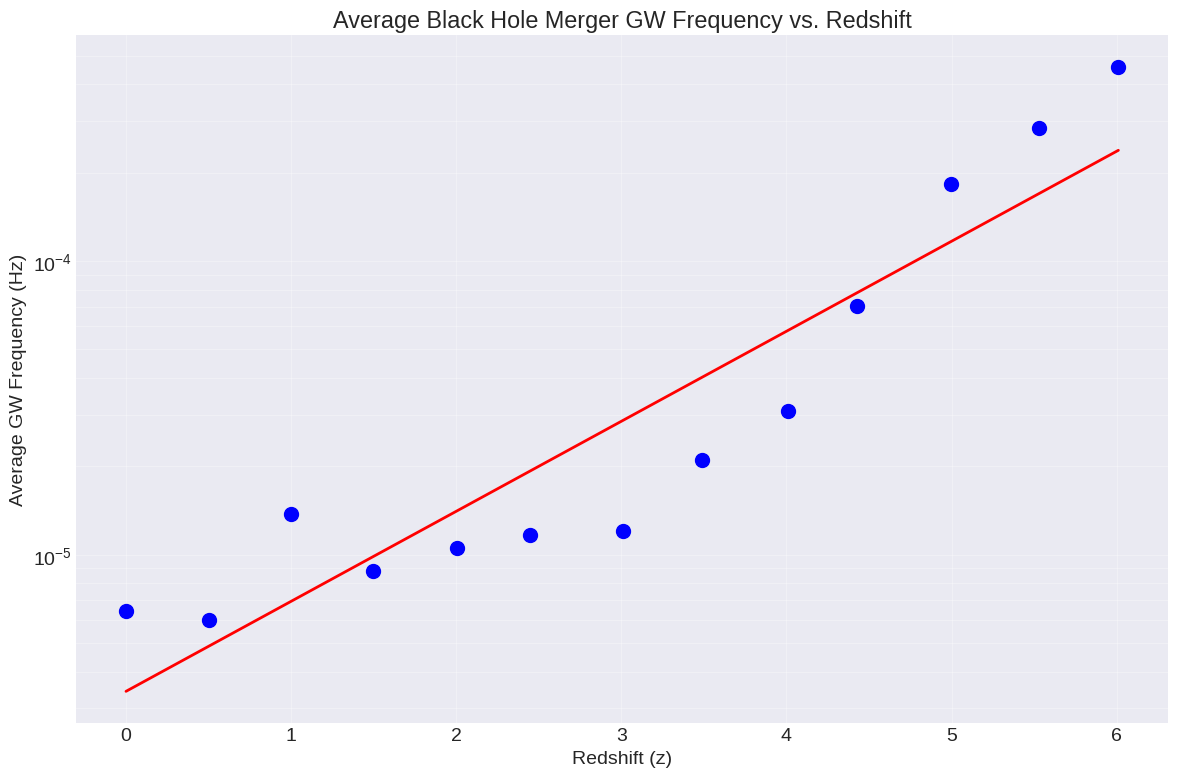

In [1]:
import requests
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Set up visualization parameters
rcParams.update({'font.size': 14})
plt.style.use('seaborn-v0_8-darkgrid')

# API setup with authentication
baseUrl = 'http://www.tng-project.org/api/'
headers = {"api-key": "128de4248c745e040927ee558a9bcd62"}

# Function to get data from the Illustris API
def get(path, params=None):
    """Make GET request to TNG API and return JSON response"""
    r = requests.get(path, params=params, headers=headers)
    r.raise_for_status()

    if r.headers['content-type'] == 'application/json':
        return r.json()

    return r

# Function to calculate frequency from BH masses and redshift
def frequency(m1, m2, z):
    """
    Calculate GW frequency from binary BH masses and redshift

    Parameters:
    m1, m2: Black hole masses in solar masses
    z: Redshift

    Returns:
    Frequency in Hz
    """
    m = m1 + m2
    return 3.9 * ((10**4) / m) * (1 / (1 + z))

def main():
    """Main function to analyze BH merger frequencies across various redshifts"""

    print("Illustris Black Hole Merger Frequency vs Redshift Analysis")
    print("--------------------------------------------------------")

    # Select TNG100-1 simulation
    print("\nRetrieving simulation information...")
    r = get(baseUrl)
    names = [sim['name'] for sim in r['simulations']]

    try:
        i = names.index('TNG100-1')
        sim_name = 'TNG100-1'
    except ValueError:
        # Fall back to Illustris-1 if TNG100-1 is not available
        i = names.index('Illustris-1')
        sim_name = 'Illustris-1'

    sim = get(r['simulations'][i]['url'])
    print(f"Selected simulation: {sim_name}")

    # Get snapshots
    print("Retrieving snapshot information...")
    snaps = get(sim['url'] + 'snapshots/')

    # Define redshift intervals (0 to 6 with 0.5 intervals)
    redshift_bins = np.arange(0, 6.5, 0.5)
    print(f"Analyzing redshift intervals: {redshift_bins}")

    # Find snapshots closest to each redshift bin
    selected_snaps = []
    for z in redshift_bins:
        closest_snap = min(snaps, key=lambda s: abs(s['redshift'] - z))
        selected_snaps.append(closest_snap)
        print(f"  - z={z}: Using snapshot {closest_snap['number']} with redshift {closest_snap['redshift']:.3f}")

    # Parameters for the subhalo search - limit to 10 most massive galaxies for efficiency
    params = {'limit': 10, 'order_by': '-mass_stars'}

    # Data storage for each redshift bin
    redshift_data = {
        'redshift': [],       # Actual redshift value
        'avg_frequency': [],  # Average frequency
        'std_frequency': [],  # Standard deviation of frequency
        'num_bhs': []         # Number of BHs found
    }

    # For plotting individual points
    all_redshifts = []
    all_frequencies = []

    # Process each snapshot
    print("\nProcessing snapshots to calculate average frequencies:")
    for snapshot in selected_snaps:
        z = snapshot['redshift']
        print(f"\nAnalyzing z = {z:.3f} (snapshot {snapshot['number']}):")

        # Retrieve subhalos
        subhalos = get(snapshot['url'] + 'subhalos/', params)
        print(f"  Retrieved {len(subhalos['results'])} subhalos")

        # Collect frequencies for this redshift
        frequencies = []

        # Process subhalos
        for i, subhalo in enumerate(subhalos['results']):
            # Get detailed subhalo data
            sub_detail = get(subhalo['url'])

            # Check if the subhalo has black holes
            if 'mass_bhs' in sub_detail and sub_detail['mass_bhs'] > 0:
                bhm = sub_detail['mass_bhs'] * 1E10  # Convert to solar masses

                # For simplicity, assume a merger with a BH that's 10-50% of the primary mass
                # In a real analysis, you'd use the merger tree data to find actual merger partners
                merger_ratio = np.random.uniform(0.1, 0.5)
                m1 = bhm
                m2 = bhm * merger_ratio

                if m1 > 0:
                    f = frequency(m1, m2, z)
                    frequencies.append(f)

                    # Store for scatter plot
                    all_redshifts.append(z)
                    all_frequencies.append(f)

                    print(f"  Subhalo {i}: BH mass: {m1:.2e} Msun, Frequency: {f:.2e} Hz")

        # Calculate statistics for this redshift
        if frequencies:
            avg_freq = np.mean(frequencies)
            std_freq = np.std(frequencies)

            redshift_data['redshift'].append(z)
            redshift_data['avg_frequency'].append(avg_freq)
            redshift_data['std_frequency'].append(std_freq)
            redshift_data['num_bhs'].append(len(frequencies))

            print(f"  Found {len(frequencies)} BHs at z = {z:.3f}")
            print(f"  Average frequency: {avg_freq:.2e} Hz ± {std_freq:.2e} Hz")
        else:
            print(f"  No black holes found at z = {z:.3f}")

    # Convert lists to numpy arrays
    for key in redshift_data:
        redshift_data[key] = np.array(redshift_data[key])

    # Generate visualizations
    print("\nGenerating visualizations...")

    # 1. Average Frequency vs. Redshift (simplified)
    plt.figure(figsize=(12, 8))

    # Plot average frequency at each redshift point
    plt.scatter(redshift_data['redshift'], redshift_data['avg_frequency'],
                s=100, color='blue', zorder=2)

    # Add a straight line of best fit
    if len(redshift_data['redshift']) > 1:
        # Use linear fit instead of polynomial
        z_range = np.linspace(min(redshift_data['redshift']), max(redshift_data['redshift']), 100)

        # Fit a straight line in log space
        coeffs = np.polyfit(redshift_data['redshift'], np.log10(redshift_data['avg_frequency']), 1)
        poly = np.poly1d(coeffs)

        # Convert back from log10 to actual frequency values
        fitted_curve = 10**(poly(z_range))
        plt.plot(z_range, fitted_curve, 'r-', linewidth=2)

    plt.yscale('log')
    plt.xlabel('Redshift (z)')
    plt.ylabel('Average GW Frequency (Hz)')
    plt.title('Average Black Hole Merger GW Frequency vs. Redshift')
    plt.grid(True, which='both', alpha=0.3)
    plt.tight_layout()
    plt.savefig('avg_frequency_vs_redshift.png')

    # We're not generating the second graph as requested

    # Print summary table
    print("\nSummary table of average frequencies by redshift:")
    print("--------------------------------------------------")
    print(f"{'Redshift':^10} | {'Avg Frequency (Hz)':^20} | {'Std Dev':^20} | {'# BHs':^8}")
    print("-" * 65)

    for z, avg, std, count in zip(redshift_data['redshift'],
                                redshift_data['avg_frequency'],
                                redshift_data['std_frequency'],
                                redshift_data['num_bhs']):
        print(f"{z:^10.3f} | {avg:^20.3e} | {std:^20.3e} | {count:^8}")

    print("\nAnalysis complete. Generated plots:")
    print("  - avg_frequency_vs_redshift.png: Average GW frequency vs. redshift with straight-line fit")

if __name__ == "__main__":
    main()